In [1]:
import pandas as pd
import os
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt

# Approach
1. Create the 10 different datasets
2. Create the 10 different models
3. Create training function.
4. Train each model 
5. Create ensemble of models
6. Pass a new sentence in and see results.

### Create datasets

In [4]:
DATA_FOLDER = 'data'
MODEL_FOLDER = 'models'
EXPERIMENT_FOLDER = 'experiment'

VALUES = ['ACHIEVEMENT', 'BENEVOLENCE', 'CONFORMITY', 'HEDONISM', 'POWER', 'SECURITY', 'SELF-DIRECTION', 'STIMULATION', 'TRADITION', 'UNIVERSALISM']

class ValueDataset(Dataset):
    
    def __init__(self, tokenizer, df): 
        self.scenarios = df['scenario'].values.tolist()
        self.N = df.shape[0]

        inp = tokenizer(self.scenarios, return_tensors='pt', padding=True, truncation=True)
        self.input_ids = inp.get('input_ids')
        self.attention_mask = inp.get('attention_mask')
        self.token_type_ids = inp.get('token_type_ids')
        self.target = df['label'].values.tolist()
    
    def __getitem__(self, index):
        return self.input_ids[index], self.attention_mask[index], self.token_type_ids[index], self.target[index]

    def __len__(self):
        return self.N

In [3]:
BATCH_SIZE = 10

# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
train_datasets = []    
test_datasets = []

for value in VALUES:
    FILE = value + '.csv'
    train_split = .8
    df = pd.read_csv(os.path.join(os.getcwd(), DATA_FOLDER, FILE))
    df_train = df.sample(frac=train_split, random_state=0)
    df_test = df.drop(df_train.index).reset_index(drop=True)

    train_datasets.append(ValueDataset(tokenizer, df_train))
    test_datasets.append(ValueDataset(tokenizer, df_test))

# Create dataloaders
train_dataloaders = []
test_dataloaders = []

for i in range(len(VALUES)):
    train_dataloaders.append(DataLoader(train_datasets[i], batch_size=BATCH_SIZE, shuffle=True))
    test_dataloaders.append(DataLoader(test_datasets[i], batch_size=len(test_datasets[i]), shuffle=False))

In [13]:
def create_data_loaders(DATA_FOLDER):
    print('Creating data loaders...')

    for value in VALUES:
        FILE = value + '.csv'
        train_split = .8
        df = pd.read_csv(os.path.join(os.getcwd(), DATA_FOLDER, FILE))
        df_train = df.sample(frac=train_split, random_state=0)
        df_test = df.drop(df_train.index).reset_index(drop=True)

        train_datasets.append(ValueDataset(tokenizer, df_train))
        test_datasets.append(ValueDataset(tokenizer, df_test))

    # Create dataloaders
    train_dataloaders = []
    test_dataloaders = []

    for i in range(len(VALUES)):
        train_dataloaders.append(DataLoader(train_datasets[i], batch_size=BATCH_SIZE, shuffle=True))
        test_dataloaders.append(DataLoader(test_datasets[i], batch_size=len(test_datasets[i]), shuffle=False))

    print('Finished creating data loaders')
    return train_dataloaders, test_dataloaders

### Create training function

In [24]:
from torch.nn import MSELoss, Tanh

def train_model(model, dataloader, loss_fn = MSELoss(), lr = 1e-5, num_epochs=10):
    tanh = Tanh()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    epoch_loss = []

    for epoch in range(num_epochs):
        model.train()
        batch_loss = []    
        for input_ids, attention_mask, token_type_ids, targets in tqdm(dataloader):
            # Forward pass
            optimizer.zero_grad()  # Clear gradients
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs.logits
            logits = tanh(logits).squeeze(-1)  # Apply tanh activation to bound outputs

            # Calculate loss
            loss = loss_fn(logits, targets.float())  # Make sure targets are floats
            batch_loss.append(loss.item())

            # Backward pass
            loss.backward()
            optimizer.step()

        # Calculate and print the average loss for the epoch
        avg_loss = np.mean(batch_loss)
        epoch_loss.append(avg_loss)
        tqdm.write(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

    return model

def train_multiple_models(models, train_dataloaders, model_name, RUN_ID, lr = 1e-5, num_epochs = 10):
    """ Train and saves multiple models """
    assert len(models) == len(train_dataloaders), 'Number of models and dataloaders must be equal'
    
    RUN_FOLDER = 'RUN_' + RUN_ID
    
    # Check if directory MODEL_FOLDER + RUN_ID exists
    assert not os.path.exists(os.path.join(os.getcwd(), MODEL_FOLDER, RUN_FOLDER)), 'Run id already exists'

    # Log experiment to file
    with open(os.path.join(os.getcwd(), EXPERIMENT_FOLDER, f'EXPERIMENT_{RUN_ID}.txt'), 'a') as f:
        f.write(f'RUN_ID: {RUN_ID}\n')
        f.write(f'Model name: {model_name}\n')
        f.write(f'Learning rate: {lr}\n')
        f.write(f'Number of epochs: {num_epochs}\n')
        f.write(f'Number of models: {len(models)}\n')
        f.write(f'Values: {VALUES}\n')

    # Create directory MODEL_FOLDER + RUN_ID
    os.mkdir(os.path.join(os.getcwd(), MODEL_FOLDER, RUN_FOLDER))

    for i in range(len(models)):
        print(f'Training model for value {VALUES[i]}')
        model = train_model(models[i], train_dataloaders[i], lr = lr, num_epochs=num_epochs)
        torch.save(model, os.path.join(os.getcwd(), MODEL_FOLDER, RUN_FOLDER, 'model_' + VALUES[i] + '.pt'))
        print(f'Completed training for model value {VALUES[i]}')

    print('Completed training for all models')

### Evaluate models

In [17]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

def get_predictions(model, test_dataloader):
    tanh = Tanh()
    model.eval()
    with torch.no_grad():
        for data in iter(test_dataloader):
            input_ids, attention_mask, token_types_ids, targets = data
            inp = {'input_ids' : input_ids, 'attention_mask' : attention_mask, 'token_type_ids' : token_types_ids}
            output = model(**inp)
            logits = output.logits
            predictions = tanh(logits).squeeze(-1)

            return predictions, targets
    

def regression_to_classification_metrics(predictions, targets):
    # Define thresholds for class assignment based on regression predictions
    thresholds = [-0.33, 0.33]

    # Convert regression predictions to discrete labels [-1, 0, 1]
    labels = np.zeros_like(predictions)
    labels[predictions < thresholds[0]] = -1
    labels[predictions > thresholds[1]] = 1

    # Calculate precision, recall, and F1 scores
    accuracy = accuracy_score(targets, labels)
    precision = precision_score(targets, labels, average='weighted')
    recall = recall_score(targets, labels, average='weighted')
    f1 = f1_score(targets, labels, average='weighted')

    return accuracy, f1, recall, precision

def evaluate_model(model, test_dataloader):
    # Report the accuracy, precision, recall, and F1 score of the model
    model.eval()

    # Get the predictions of the model
    predictions, targets = get_predictions(model, test_dataloader)

    # Calculate the metrics
    accuracy, f1, recall, precision = regression_to_classification_metrics(predictions, targets)

    return accuracy, f1, recall, precision

def evaluate_multiple_models(models, test_dataloaders, write = False, RUN_ID = None):
    assert not (write and RUN_ID is None), 'Must specify RUN_ID if writing to file'

    RUN_FOLDER = 'RUN_' + RUN_ID
    # Create metrics.txt file in the results folder
    if write:
        if not os.path.exists(os.path.join(os.getcwd(), 'results', RUN_FOLDER)):
            os.mkdir(os.path.join(os.getcwd(), 'results', RUN_FOLDER))

        with open(os.path.join(os.getcwd(), 'results', RUN_FOLDER, 'metrics.txt'), 'a+') as f:
            f.write('model, accuracy, f1, recall, precision\n') 

    for i in range(len(models)):
        print(f'Evaluating model for value {VALUES[i]}')
        accuracy, f1, recall, precision = evaluate_model(models[i], test_dataloaders[i])
        print(f'Completed evaluation for model value {VALUES[i]}')

        if write:
            with open(os.path.join(os.getcwd(), 'results', RUN_FOLDER, 'metrics.txt'), 'a+') as f:
                f.write(f'model_{VALUES[i]}: {accuracy}, {f1}, {recall}, {precision}\n')

### Create value profile for new sentence

In [11]:
sentence = 'I am a good person'

def create_value_profile(sentence, models, tokenizer):
    tanh = Tanh()
    predictions = []

    for model in models:
        model.eval()
        with torch.no_grad():
            inp = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
            input_ids = inp.get('input_ids')
            attention_mask = inp.get('attention_mask')
            token_type_ids = inp.get('token_type_ids')
            output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = output.logits
            prediction = tanh(logits).squeeze(-1)

            predictions.append(prediction.detach().numpy().item())

    return predictions

def plot_value_profile(profile, sentence):

    num_vars = 10

    values = profile

    # Compute angle each bar is centered on:
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is made circular by appending a copy of the first value to the end
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Draw the outline of our data:
    ax.fill(angles, values, color='blue', alpha=0.25)

    # Draw a line around the data:
    ax.plot(angles, values, color='blue', linewidth=2)

    # Fix the axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_ylim(-1, 1)

    # Draw axis lines for each angle and label:
    labels = ['ACHIEVEMENT', 'BENEVOLENCE', 'CONFORMITY', 'HEDONISM', 'POWER', 
            'SECURITY', 'SELF-DIRECTION', 'STIMULATION', 'TRADITION', 'UNIVERSALISM']
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    # Set the title of the plot
    ax.set_title(f's: {sentence}', size=20, color='blue', y=1.1)

    plt.show()

### Design Experiment
1. Define models and train them
2. Evaluate models
3. Test different sentences to see value profile

In [9]:
import warnings

MODEL_NAME = 'prajjwal1/bert-small'
models = []

for i in range(len(VALUES)):
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
    models.append(model)


def create_models(MODEL_NAME):
    print('Creating models...')
    models = []

    for i in range(len(VALUES)):
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
        models.append(model)

    print('Models created')

    return models

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-s

In [10]:
evaluate_multiple_models(models, test_dataloaders, write = True, RUN_ID = '3')

Evaluating model for value ACHIEVEMENT
Completed evaluation for model value ACHIEVEMENT
Evaluating model for value BENEVOLENCE
Completed evaluation for model value BENEVOLENCE
Evaluating model for value CONFORMITY
Completed evaluation for model value CONFORMITY
Evaluating model for value HEDONISM
Completed evaluation for model value HEDONISM
Evaluating model for value POWER
Completed evaluation for model value POWER
Evaluating model for value SECURITY
Completed evaluation for model value SECURITY
Evaluating model for value SELF-DIRECTION
Completed evaluation for model value SELF-DIRECTION
Evaluating model for value STIMULATION
Completed evaluation for model value STIMULATION
Evaluating model for value TRADITION
Completed evaluation for model value TRADITION
Evaluating model for value UNIVERSALISM
Completed evaluation for model value UNIVERSALISM


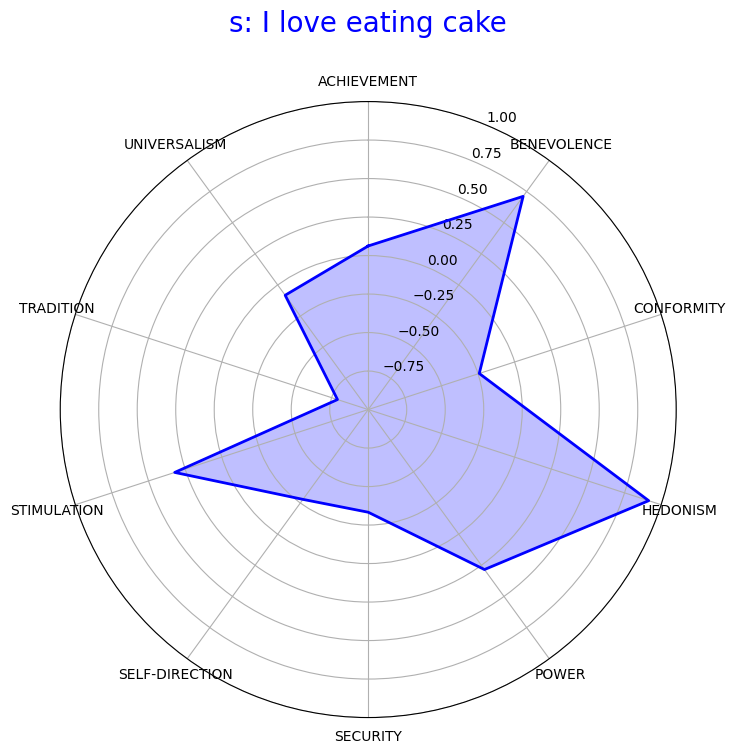

In [19]:
sentence = 'I love eating cake'

profile = create_value_profile(sentence, models, tokenizer)

plot_value_profile(profile, sentence)

In [28]:
def train_evaluate_multi_models(DATASET, MODEL_NAME, RUN_ID, lr = 1e-5, num_epochs = 50):
    """ Function trains multiple models on dataset and then returns evaluation metrics """
    DATA_FOLDER = os.path.join(os.getcwd(), 'data', DATASET)

    train_dataloaders, test_dataloaders = create_data_loaders(DATA_FOLDER)
    models = create_models(MODEL_NAME)
    train_multiple_models(models, train_dataloaders, MODEL_NAME, RUN_ID, lr = lr, num_epochs = num_epochs)
    evaluate_multiple_models(models, test_dataloaders, write = True, RUN_ID = RUN_ID)


train_evaluate_multi_models('v0.3_balanced', 'prajjwal1/bert-small', '5', lr = 1e-5, num_epochs = 50)

Creating data loaders...
Finished creating data loaders
Creating models...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-s

Models created
Training model for value ACHIEVEMENT


100%|██████████| 69/69 [00:14<00:00,  4.80it/s]


Epoch 1/50, Loss: 0.6207069724366285


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 2/50, Loss: 0.48662079136440717


100%|██████████| 69/69 [00:13<00:00,  4.96it/s]


Epoch 3/50, Loss: 0.43211369691551593


100%|██████████| 69/69 [00:13<00:00,  4.96it/s]


Epoch 4/50, Loss: 0.3575370070942934


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 5/50, Loss: 0.3019645899750184


100%|██████████| 69/69 [00:13<00:00,  4.96it/s]


Epoch 6/50, Loss: 0.25205545570107474


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 7/50, Loss: 0.21442390827165134


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 8/50, Loss: 0.19348664419806522


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 9/50, Loss: 0.16785121806289838


100%|██████████| 69/69 [00:13<00:00,  4.96it/s]


Epoch 10/50, Loss: 0.13073503490591395


100%|██████████| 69/69 [00:13<00:00,  4.96it/s]


Epoch 11/50, Loss: 0.11842752420815869


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 12/50, Loss: 0.10836896851010945


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 13/50, Loss: 0.09046359495192334


100%|██████████| 69/69 [00:13<00:00,  4.93it/s]


Epoch 14/50, Loss: 0.07552166590872018


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 15/50, Loss: 0.07253682899518289


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 16/50, Loss: 0.06887853215785994


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 17/50, Loss: 0.06455305102618708


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 18/50, Loss: 0.05181110285870407


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 19/50, Loss: 0.05552367295098046


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 20/50, Loss: 0.04867186065277328


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 21/50, Loss: 0.0560211764405603


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 22/50, Loss: 0.05042603412859034


100%|██████████| 69/69 [00:14<00:00,  4.89it/s]


Epoch 23/50, Loss: 0.046055364732940994


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 24/50, Loss: 0.043928086123280766


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 25/50, Loss: 0.04551804283012947


100%|██████████| 69/69 [00:13<00:00,  4.93it/s]


Epoch 26/50, Loss: 0.04406071469133747


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 27/50, Loss: 0.043281126220751066


100%|██████████| 69/69 [00:13<00:00,  4.93it/s]


Epoch 28/50, Loss: 0.04107580035654963


100%|██████████| 69/69 [00:14<00:00,  4.92it/s]


Epoch 29/50, Loss: 0.03663258573067361


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 30/50, Loss: 0.03628703552986617


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 31/50, Loss: 0.037882772409289646


100%|██████████| 69/69 [00:13<00:00,  4.96it/s]


Epoch 32/50, Loss: 0.036848417881444315


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 33/50, Loss: 0.03757675565050348


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 34/50, Loss: 0.030697439959191757


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 35/50, Loss: 0.03622075612994208


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 36/50, Loss: 0.02688419851946874


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 37/50, Loss: 0.026894805068825033


100%|██████████| 69/69 [00:13<00:00,  4.93it/s]


Epoch 38/50, Loss: 0.03154224107392888


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


Epoch 39/50, Loss: 0.02808324066058233


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 40/50, Loss: 0.03251911973769682


100%|██████████| 69/69 [00:13<00:00,  4.96it/s]


Epoch 41/50, Loss: 0.02937124861215336


100%|██████████| 69/69 [00:13<00:00,  4.97it/s]


Epoch 42/50, Loss: 0.029939809682495568


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 43/50, Loss: 0.02621630776970499


100%|██████████| 69/69 [00:13<00:00,  4.93it/s]


Epoch 44/50, Loss: 0.027534876649767375


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 45/50, Loss: 0.02505311004790491


100%|██████████| 69/69 [00:13<00:00,  4.98it/s]


Epoch 46/50, Loss: 0.02474284403876442


100%|██████████| 69/69 [00:13<00:00,  4.99it/s]


Epoch 47/50, Loss: 0.02214714750121145


100%|██████████| 69/69 [00:13<00:00,  4.97it/s]


Epoch 48/50, Loss: 0.025090640535632123


100%|██████████| 69/69 [00:13<00:00,  5.01it/s]


Epoch 49/50, Loss: 0.025026757168867018


100%|██████████| 69/69 [00:13<00:00,  5.08it/s]


Epoch 50/50, Loss: 0.02189147917121865
Completed training for model value ACHIEVEMENT
Training model for value BENEVOLENCE


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 1/50, Loss: 0.42472958295372487


100%|██████████| 614/614 [02:30<00:00,  4.09it/s]


Epoch 2/50, Loss: 0.37247787033744667


100%|██████████| 614/614 [02:29<00:00,  4.12it/s]


Epoch 3/50, Loss: 0.3329329892859494


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 4/50, Loss: 0.2974270180122569


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 5/50, Loss: 0.26262460952982647


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 6/50, Loss: 0.2258275511586608


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 7/50, Loss: 0.19279602445140237


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 8/50, Loss: 0.1671626000037168


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 9/50, Loss: 0.14660139979054418


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 10/50, Loss: 0.12784857608845113


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 11/50, Loss: 0.11423017632774402


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 12/50, Loss: 0.10573687738396155


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 13/50, Loss: 0.09229965353496858


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 14/50, Loss: 0.08742102595191777


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 15/50, Loss: 0.0782003891199269


100%|██████████| 614/614 [02:31<00:00,  4.07it/s]


Epoch 16/50, Loss: 0.07466026049726172


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 17/50, Loss: 0.06511065345454706


100%|██████████| 614/614 [02:31<00:00,  4.07it/s]


Epoch 18/50, Loss: 0.0630037935243249


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 19/50, Loss: 0.058877842896314585


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 20/50, Loss: 0.05604894762591031


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 21/50, Loss: 0.05231312152069572


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 22/50, Loss: 0.04992418683112026


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 23/50, Loss: 0.045186092991837686


100%|██████████| 614/614 [02:33<00:00,  3.99it/s]


Epoch 24/50, Loss: 0.044792594132828906


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 25/50, Loss: 0.0443717590790107


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 26/50, Loss: 0.039325697388286104


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 27/50, Loss: 0.036623489978425176


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 28/50, Loss: 0.034429967503142256


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 29/50, Loss: 0.03433158964029413


100%|██████████| 614/614 [02:31<00:00,  4.05it/s]


Epoch 30/50, Loss: 0.0330793370999182


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 31/50, Loss: 0.0314744224051182


100%|██████████| 614/614 [02:31<00:00,  4.05it/s]


Epoch 32/50, Loss: 0.02849525336984997


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 33/50, Loss: 0.02655693957683932


100%|██████████| 614/614 [02:29<00:00,  4.10it/s]


Epoch 34/50, Loss: 0.02615316982547137


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 35/50, Loss: 0.023534397163287302


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 36/50, Loss: 0.021479840586313647


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 37/50, Loss: 0.021821501363943452


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 38/50, Loss: 0.019282424296127768


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 39/50, Loss: 0.018179399244689115


100%|██████████| 614/614 [02:33<00:00,  4.00it/s]


Epoch 40/50, Loss: 0.01746638419969005


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 41/50, Loss: 0.015745164422139735


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 42/50, Loss: 0.014397213217580133


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 43/50, Loss: 0.01450229165530246


100%|██████████| 614/614 [02:31<00:00,  4.05it/s]


Epoch 44/50, Loss: 0.012505523789970201


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 45/50, Loss: 0.012007383368788014


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 46/50, Loss: 0.012435265306471252


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 47/50, Loss: 0.01014929917401707


100%|██████████| 614/614 [02:30<00:00,  4.07it/s]


Epoch 48/50, Loss: 0.010252013409354117


100%|██████████| 614/614 [02:31<00:00,  4.04it/s]


Epoch 49/50, Loss: 0.00969496440765803


100%|██████████| 614/614 [02:31<00:00,  4.06it/s]


Epoch 50/50, Loss: 0.009605614828212313
Completed training for model value BENEVOLENCE
Training model for value CONFORMITY


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 1/50, Loss: 0.31020722232314923


100%|██████████| 151/151 [00:33<00:00,  4.47it/s]


Epoch 2/50, Loss: 0.2628880398261626


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 3/50, Loss: 0.22229213975616638


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 4/50, Loss: 0.1895053968857357


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 5/50, Loss: 0.1639557093665596


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 6/50, Loss: 0.1352376408785557


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 7/50, Loss: 0.11190239901944304


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 8/50, Loss: 0.08916099928319454


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 9/50, Loss: 0.07605429902820793


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 10/50, Loss: 0.06484123407739727


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Epoch 11/50, Loss: 0.05329715221694714


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 12/50, Loss: 0.04944983156188237


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 13/50, Loss: 0.0421999503314088


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 14/50, Loss: 0.03750202701880368


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 15/50, Loss: 0.03178173611680699


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Epoch 16/50, Loss: 0.03482631917207175


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 17/50, Loss: 0.02934947660013984


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 18/50, Loss: 0.025445955991282417


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 19/50, Loss: 0.02596814150494887


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 20/50, Loss: 0.025283876713211122


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 21/50, Loss: 0.024531876140513876


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Epoch 22/50, Loss: 0.022452700791405576


100%|██████████| 151/151 [00:33<00:00,  4.47it/s]


Epoch 23/50, Loss: 0.019076995764179032


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 24/50, Loss: 0.017667478586497736


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 25/50, Loss: 0.016188359503450784


100%|██████████| 151/151 [00:33<00:00,  4.46it/s]


Epoch 26/50, Loss: 0.017291681020615457


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 27/50, Loss: 0.01584779480352708


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 28/50, Loss: 0.016990032395893796


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 29/50, Loss: 0.013548193658071429


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 30/50, Loss: 0.01559967067114244


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 31/50, Loss: 0.01278807840538242


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 32/50, Loss: 0.01151540111112393


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 33/50, Loss: 0.011563090644722853


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Epoch 34/50, Loss: 0.010991482367067958


100%|██████████| 151/151 [00:33<00:00,  4.48it/s]


Epoch 35/50, Loss: 0.011596105834650376


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 36/50, Loss: 0.010899677675387773


100%|██████████| 151/151 [00:34<00:00,  4.42it/s]


Epoch 37/50, Loss: 0.00999660682388418


100%|██████████| 151/151 [00:35<00:00,  4.24it/s]


Epoch 38/50, Loss: 0.00984885990747832


100%|██████████| 151/151 [00:33<00:00,  4.44it/s]


Epoch 39/50, Loss: 0.009277638891029144


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 40/50, Loss: 0.008786791533409827


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 41/50, Loss: 0.00962035353123966


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 42/50, Loss: 0.008802153113057577


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 43/50, Loss: 0.00845165964758944


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 44/50, Loss: 0.0086058222756001


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 45/50, Loss: 0.008605549327349938


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 46/50, Loss: 0.00932694279526311


100%|██████████| 151/151 [00:33<00:00,  4.49it/s]


Epoch 47/50, Loss: 0.0069410607866543525


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 48/50, Loss: 0.007133984290896406


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 49/50, Loss: 0.008044786086315227


100%|██████████| 151/151 [00:33<00:00,  4.50it/s]


Epoch 50/50, Loss: 0.007551752256548698
Completed training for model value CONFORMITY
Training model for value HEDONISM


100%|██████████| 173/173 [00:35<00:00,  4.81it/s]


Epoch 1/50, Loss: 0.5624111235314022


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 2/50, Loss: 0.4638055734379443


100%|██████████| 173/173 [00:36<00:00,  4.80it/s]


Epoch 3/50, Loss: 0.37843856891627947


100%|██████████| 173/173 [00:35<00:00,  4.81it/s]


Epoch 4/50, Loss: 0.3203202487330216


100%|██████████| 173/173 [00:35<00:00,  4.81it/s]


Epoch 5/50, Loss: 0.27351187974903624


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 6/50, Loss: 0.22772455348961615


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 7/50, Loss: 0.20577279314657168


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 8/50, Loss: 0.17264294861196783


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 9/50, Loss: 0.1410933763779312


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 10/50, Loss: 0.11823659482805025


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 11/50, Loss: 0.10596914181345804


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 12/50, Loss: 0.09994721809951211


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 13/50, Loss: 0.08259592422235736


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 14/50, Loss: 0.07826601246081163


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 15/50, Loss: 0.07163612831470077


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 16/50, Loss: 0.06628159953098249


100%|██████████| 173/173 [00:36<00:00,  4.79it/s]


Epoch 17/50, Loss: 0.05996944382248414


100%|██████████| 173/173 [00:35<00:00,  4.83it/s]


Epoch 18/50, Loss: 0.054144653270957785


100%|██████████| 173/173 [00:35<00:00,  4.81it/s]


Epoch 19/50, Loss: 0.05293905378098605


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 20/50, Loss: 0.052332821870061184


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 21/50, Loss: 0.043191280995893984


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 22/50, Loss: 0.043967391369659777


100%|██████████| 173/173 [00:35<00:00,  4.81it/s]


Epoch 23/50, Loss: 0.04227882598639827


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 24/50, Loss: 0.043084435547147526


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 25/50, Loss: 0.0404152673604559


100%|██████████| 173/173 [00:35<00:00,  4.83it/s]


Epoch 26/50, Loss: 0.0369859252897538


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 27/50, Loss: 0.03473769787246781


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 28/50, Loss: 0.033797371462983415


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 29/50, Loss: 0.0358627366576333


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 30/50, Loss: 0.031849359162151814


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 31/50, Loss: 0.03308630870477528


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 32/50, Loss: 0.028122815120469973


100%|██████████| 173/173 [00:35<00:00,  4.81it/s]


Epoch 33/50, Loss: 0.025908619806041262


100%|██████████| 173/173 [00:35<00:00,  4.81it/s]


Epoch 34/50, Loss: 0.026250982595166204


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 35/50, Loss: 0.023499074795773265


100%|██████████| 173/173 [00:36<00:00,  4.80it/s]


Epoch 36/50, Loss: 0.02315573565220471


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 37/50, Loss: 0.022017859371992722


100%|██████████| 173/173 [00:35<00:00,  4.81it/s]


Epoch 38/50, Loss: 0.022843728696582893


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 39/50, Loss: 0.020442588689516303


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 40/50, Loss: 0.015950603777343527


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 41/50, Loss: 0.017809080370470364


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 42/50, Loss: 0.017250638473657837


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 43/50, Loss: 0.014368303810553141


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 44/50, Loss: 0.01948395423352923


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 45/50, Loss: 0.015310635720581526


100%|██████████| 173/173 [00:35<00:00,  4.82it/s]


Epoch 46/50, Loss: 0.014529899273449932


100%|██████████| 173/173 [00:35<00:00,  4.86it/s]


Epoch 47/50, Loss: 0.013486951284919398


100%|██████████| 173/173 [00:36<00:00,  4.78it/s]


Epoch 48/50, Loss: 0.011378807075606992


100%|██████████| 173/173 [00:35<00:00,  4.90it/s]


Epoch 49/50, Loss: 0.010059618702658986


100%|██████████| 173/173 [00:35<00:00,  4.87it/s]


Epoch 50/50, Loss: 0.010705129774031633
Completed training for model value HEDONISM
Training model for value POWER


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 1/50, Loss: 0.7734910102797227


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 2/50, Loss: 0.6380674973340101


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 3/50, Loss: 0.5560423324645405


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 4/50, Loss: 0.4860035080305288


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 5/50, Loss: 0.4337523331944372


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 6/50, Loss: 0.3633840627653498


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 7/50, Loss: 0.2886552323757763


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 8/50, Loss: 0.24143679025517384


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 9/50, Loss: 0.19060868853834315


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 10/50, Loss: 0.14940522752807173


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 11/50, Loss: 0.116619341770633


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 12/50, Loss: 0.1030635998754854


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 13/50, Loss: 0.08218293243520697


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 14/50, Loss: 0.0826513879263485


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 15/50, Loss: 0.07702774770925162


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 16/50, Loss: 0.06332140688089208


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 17/50, Loss: 0.06812018735176871


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 18/50, Loss: 0.06093352002052354


100%|██████████| 71/71 [00:13<00:00,  5.21it/s]


Epoch 19/50, Loss: 0.058323384413469424


100%|██████████| 71/71 [00:14<00:00,  5.06it/s]


Epoch 20/50, Loss: 0.04706714732546202


100%|██████████| 71/71 [00:13<00:00,  5.16it/s]


Epoch 21/50, Loss: 0.04677838739663572


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 22/50, Loss: 0.045596992173953584


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 23/50, Loss: 0.051926792730433


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 24/50, Loss: 0.048126679320465514


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 25/50, Loss: 0.04088889029283654


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 26/50, Loss: 0.04493856700924291


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 27/50, Loss: 0.04181512765927424


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 28/50, Loss: 0.04009645516184014


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 29/50, Loss: 0.04589249592431834


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 30/50, Loss: 0.04170054253059584


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 31/50, Loss: 0.03560962101680712


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 32/50, Loss: 0.03976909806427192


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 33/50, Loss: 0.03782075080482788


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 34/50, Loss: 0.03405954830125499


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 35/50, Loss: 0.03731884297088418


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 36/50, Loss: 0.03376737606226349


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 37/50, Loss: 0.03590825023654271


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 38/50, Loss: 0.03170354353775546


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 39/50, Loss: 0.03545505220962452


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 40/50, Loss: 0.03343969251317772


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 41/50, Loss: 0.03440729654590848


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 42/50, Loss: 0.031829217599678626


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 43/50, Loss: 0.03151700774889807


100%|██████████| 71/71 [00:13<00:00,  5.16it/s]


Epoch 44/50, Loss: 0.028025748604961053


100%|██████████| 71/71 [00:13<00:00,  5.10it/s]


Epoch 45/50, Loss: 0.028893771627262026


100%|██████████| 71/71 [00:13<00:00,  5.18it/s]


Epoch 46/50, Loss: 0.03028906238409625


100%|██████████| 71/71 [00:13<00:00,  5.23it/s]


Epoch 47/50, Loss: 0.03032331409188591


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 48/50, Loss: 0.02912698774664125


100%|██████████| 71/71 [00:13<00:00,  5.24it/s]


Epoch 49/50, Loss: 0.027888909070818146


100%|██████████| 71/71 [00:13<00:00,  5.25it/s]


Epoch 50/50, Loss: 0.022848722305227543
Completed training for model value POWER
Training model for value SECURITY


100%|██████████| 296/296 [01:01<00:00,  4.83it/s]


Epoch 1/50, Loss: 0.5674179899632126


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 2/50, Loss: 0.5328265542818887


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 3/50, Loss: 0.491711417062057


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 4/50, Loss: 0.44634447629387314


100%|██████████| 296/296 [01:02<00:00,  4.72it/s]


Epoch 5/50, Loss: 0.3965141586455944


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 6/50, Loss: 0.3381713018878489


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 7/50, Loss: 0.28587956989586755


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 8/50, Loss: 0.23462493543991367


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 9/50, Loss: 0.19642514928017515


100%|██████████| 296/296 [01:02<00:00,  4.74it/s]


Epoch 10/50, Loss: 0.16970383788685542


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 11/50, Loss: 0.15142244336547683


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 12/50, Loss: 0.1366574061732437


100%|██████████| 296/296 [01:03<00:00,  4.63it/s]


Epoch 13/50, Loss: 0.1193912348810684


100%|██████████| 296/296 [01:01<00:00,  4.79it/s]


Epoch 14/50, Loss: 0.11778067755261185


100%|██████████| 296/296 [01:02<00:00,  4.77it/s]


Epoch 15/50, Loss: 0.11169260107861781


100%|██████████| 296/296 [01:01<00:00,  4.78it/s]


Epoch 16/50, Loss: 0.10228747995318593


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 17/50, Loss: 0.08866104162675706


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 18/50, Loss: 0.09074152065315158


100%|██████████| 296/296 [01:01<00:00,  4.81it/s]


Epoch 19/50, Loss: 0.07801679141089521


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 20/50, Loss: 0.07513929618132376


100%|██████████| 296/296 [01:02<00:00,  4.74it/s]


Epoch 21/50, Loss: 0.07452010892086185


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 22/50, Loss: 0.07472207992513841


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 23/50, Loss: 0.06838674127829035


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 24/50, Loss: 0.06796083221451153


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 25/50, Loss: 0.0602290909233931


100%|██████████| 296/296 [01:02<00:00,  4.72it/s]


Epoch 26/50, Loss: 0.06274285780051975


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 27/50, Loss: 0.0573144155944622


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 28/50, Loss: 0.05435549079698536


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 29/50, Loss: 0.05383420167994257


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 30/50, Loss: 0.05080646496089931


100%|██████████| 296/296 [01:02<00:00,  4.77it/s]


Epoch 31/50, Loss: 0.05086375946710767


100%|██████████| 296/296 [01:02<00:00,  4.77it/s]


Epoch 32/50, Loss: 0.050111425895797646


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 33/50, Loss: 0.04729478622352503


100%|██████████| 296/296 [01:01<00:00,  4.79it/s]


Epoch 34/50, Loss: 0.04529689166952881


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 35/50, Loss: 0.047230800259795445


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 36/50, Loss: 0.04086911572439193


100%|██████████| 296/296 [01:02<00:00,  4.74it/s]


Epoch 37/50, Loss: 0.040132397181681684


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 38/50, Loss: 0.03849538939382025


100%|██████████| 296/296 [01:01<00:00,  4.79it/s]


Epoch 39/50, Loss: 0.03792543990720013


100%|██████████| 296/296 [01:01<00:00,  4.79it/s]


Epoch 40/50, Loss: 0.037641469574835454


100%|██████████| 296/296 [01:01<00:00,  4.79it/s]


Epoch 41/50, Loss: 0.03444345511348188


100%|██████████| 296/296 [01:02<00:00,  4.75it/s]


Epoch 42/50, Loss: 0.032514554108618886


100%|██████████| 296/296 [01:01<00:00,  4.79it/s]


Epoch 43/50, Loss: 0.032196491507961215


100%|██████████| 296/296 [01:01<00:00,  4.79it/s]


Epoch 44/50, Loss: 0.027856986312906735


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 45/50, Loss: 0.026767910628837557


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 46/50, Loss: 0.024761018436874036


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 47/50, Loss: 0.023669313245812413


100%|██████████| 296/296 [01:02<00:00,  4.74it/s]


Epoch 48/50, Loss: 0.019898100444619114


100%|██████████| 296/296 [01:01<00:00,  4.80it/s]


Epoch 49/50, Loss: 0.018356960836516355


100%|██████████| 296/296 [01:01<00:00,  4.78it/s]


Epoch 50/50, Loss: 0.018346165163313492
Completed training for model value SECURITY
Training model for value SELF-DIRECTION


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Epoch 1/50, Loss: 0.5733489233713883


100%|██████████| 26/26 [00:05<00:00,  5.01it/s]


Epoch 2/50, Loss: 0.5455911354376719


100%|██████████| 26/26 [00:05<00:00,  5.00it/s]


Epoch 3/50, Loss: 0.4986516357614444


100%|██████████| 26/26 [00:05<00:00,  5.01it/s]


Epoch 4/50, Loss: 0.44284906123693174


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Epoch 5/50, Loss: 0.41134017820541674


100%|██████████| 26/26 [00:05<00:00,  5.00it/s]


Epoch 6/50, Loss: 0.3815974902648192


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Epoch 7/50, Loss: 0.31682629654040706


100%|██████████| 26/26 [00:05<00:00,  4.95it/s]


Epoch 8/50, Loss: 0.29575912138590443


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Epoch 9/50, Loss: 0.24771027066386664


100%|██████████| 26/26 [00:05<00:00,  4.94it/s]


Epoch 10/50, Loss: 0.19937973870680883


100%|██████████| 26/26 [00:05<00:00,  5.01it/s]


Epoch 11/50, Loss: 0.20037408402332893


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Epoch 12/50, Loss: 0.16917246766388416


100%|██████████| 26/26 [00:05<00:00,  4.98it/s]


Epoch 13/50, Loss: 0.1431581794929046


100%|██████████| 26/26 [00:05<00:00,  5.00it/s]


Epoch 14/50, Loss: 0.120361372255362


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Epoch 15/50, Loss: 0.09566389239178254


100%|██████████| 26/26 [00:05<00:00,  5.00it/s]


Epoch 16/50, Loss: 0.09414068065010585


100%|██████████| 26/26 [00:05<00:00,  4.99it/s]


Epoch 17/50, Loss: 0.09396318102685305


100%|██████████| 26/26 [00:05<00:00,  5.06it/s]


Epoch 18/50, Loss: 0.07545982387203437


100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


Epoch 19/50, Loss: 0.07846273381549579


100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


Epoch 20/50, Loss: 0.07824755517336038


100%|██████████| 26/26 [00:05<00:00,  5.05it/s]


Epoch 21/50, Loss: 0.07176603061648515


100%|██████████| 26/26 [00:05<00:00,  5.05it/s]


Epoch 22/50, Loss: 0.07633088142252885


100%|██████████| 26/26 [00:05<00:00,  5.03it/s]


Epoch 23/50, Loss: 0.058988649469728656


100%|██████████| 26/26 [00:05<00:00,  5.06it/s]


Epoch 24/50, Loss: 0.060709287913946


100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


Epoch 25/50, Loss: 0.04699312107494244


100%|██████████| 26/26 [00:05<00:00,  5.06it/s]


Epoch 26/50, Loss: 0.055795996163326964


100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


Epoch 27/50, Loss: 0.058255101912296735


100%|██████████| 26/26 [00:05<00:00,  5.05it/s]


Epoch 28/50, Loss: 0.053237515716598585


100%|██████████| 26/26 [00:05<00:00,  5.03it/s]


Epoch 29/50, Loss: 0.060847203963651106


100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


Epoch 30/50, Loss: 0.04964004922658205


100%|██████████| 26/26 [00:05<00:00,  5.08it/s]


Epoch 31/50, Loss: 0.0462830221423736


100%|██████████| 26/26 [00:05<00:00,  4.94it/s]


Epoch 32/50, Loss: 0.04334293714223


100%|██████████| 26/26 [00:05<00:00,  4.85it/s]


Epoch 33/50, Loss: 0.04849334190098139


100%|██████████| 26/26 [00:05<00:00,  4.78it/s]


Epoch 34/50, Loss: 0.044781371915283114


100%|██████████| 26/26 [00:05<00:00,  4.77it/s]


Epoch 35/50, Loss: 0.04422747798693868


100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


Epoch 36/50, Loss: 0.04266351676331116


100%|██████████| 26/26 [00:05<00:00,  5.05it/s]


Epoch 37/50, Loss: 0.04668160771521238


100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


Epoch 38/50, Loss: 0.043375748496216074


100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


Epoch 39/50, Loss: 0.03846533152346428


100%|██████████| 26/26 [00:05<00:00,  4.98it/s]


Epoch 40/50, Loss: 0.039988950897867866


100%|██████████| 26/26 [00:05<00:00,  4.95it/s]


Epoch 41/50, Loss: 0.03887981484429194


100%|██████████| 26/26 [00:05<00:00,  4.93it/s]


Epoch 42/50, Loss: 0.0379728227853775


100%|██████████| 26/26 [00:05<00:00,  4.97it/s]


Epoch 43/50, Loss: 0.0363462300469669


100%|██████████| 26/26 [00:05<00:00,  4.92it/s]


Epoch 44/50, Loss: 0.04248178377747536


100%|██████████| 26/26 [00:05<00:00,  4.95it/s]


Epoch 45/50, Loss: 0.03588270471216394


100%|██████████| 26/26 [00:05<00:00,  4.92it/s]


Epoch 46/50, Loss: 0.03330021013075916


100%|██████████| 26/26 [00:05<00:00,  5.00it/s]


Epoch 47/50, Loss: 0.03937947553081008


100%|██████████| 26/26 [00:05<00:00,  5.04it/s]


Epoch 48/50, Loss: 0.03527846001088619


100%|██████████| 26/26 [00:05<00:00,  5.05it/s]


Epoch 49/50, Loss: 0.028108266432984516


100%|██████████| 26/26 [00:05<00:00,  5.03it/s]


Epoch 50/50, Loss: 0.03839465073094918
Completed training for model value SELF-DIRECTION
Training model for value STIMULATION


100%|██████████| 103/103 [00:19<00:00,  5.26it/s]


Epoch 1/50, Loss: 0.5761959954951573


100%|██████████| 103/103 [00:19<00:00,  5.26it/s]


Epoch 2/50, Loss: 0.47571733210561346


100%|██████████| 103/103 [00:19<00:00,  5.24it/s]


Epoch 3/50, Loss: 0.42689029395001604


100%|██████████| 103/103 [00:19<00:00,  5.25it/s]


Epoch 4/50, Loss: 0.33937923111093854


100%|██████████| 103/103 [00:19<00:00,  5.24it/s]


Epoch 5/50, Loss: 0.29729864008507684


100%|██████████| 103/103 [00:20<00:00,  5.15it/s]


Epoch 6/50, Loss: 0.24977964003687925


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 7/50, Loss: 0.21978470173130915


100%|██████████| 103/103 [00:20<00:00,  5.15it/s]


Epoch 8/50, Loss: 0.17886309372713266


100%|██████████| 103/103 [00:19<00:00,  5.16it/s]


Epoch 9/50, Loss: 0.14918131515094377


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 10/50, Loss: 0.1273514468910046


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 11/50, Loss: 0.11025574783460029


100%|██████████| 103/103 [00:20<00:00,  5.10it/s]


Epoch 12/50, Loss: 0.10177675755784928


100%|██████████| 103/103 [00:20<00:00,  4.97it/s]


Epoch 13/50, Loss: 0.0933946824081025


100%|██████████| 103/103 [00:20<00:00,  5.15it/s]


Epoch 14/50, Loss: 0.07728536048614719


100%|██████████| 103/103 [00:20<00:00,  5.08it/s]


Epoch 15/50, Loss: 0.07586889554863994


100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


Epoch 16/50, Loss: 0.06804466529667956


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 17/50, Loss: 0.06708317056515263


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 18/50, Loss: 0.06329109398105624


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 19/50, Loss: 0.057222344216357156


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 20/50, Loss: 0.05722939150715337


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 21/50, Loss: 0.05437337255412803


100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


Epoch 22/50, Loss: 0.054982372469187364


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 23/50, Loss: 0.04760073199506524


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 24/50, Loss: 0.04784810337807658


100%|██████████| 103/103 [00:20<00:00,  5.15it/s]


Epoch 25/50, Loss: 0.043098096111879765


100%|██████████| 103/103 [00:19<00:00,  5.15it/s]


Epoch 26/50, Loss: 0.042533990535975515


100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


Epoch 27/50, Loss: 0.04310517619788936


100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


Epoch 28/50, Loss: 0.04454592916011376


100%|██████████| 103/103 [00:20<00:00,  4.98it/s]


Epoch 29/50, Loss: 0.039203251056481626


100%|██████████| 103/103 [00:20<00:00,  5.10it/s]


Epoch 30/50, Loss: 0.04012604919940378


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 31/50, Loss: 0.03616820863059279


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 32/50, Loss: 0.034020591111293116


100%|██████████| 103/103 [00:20<00:00,  5.14it/s]


Epoch 33/50, Loss: 0.035195615743874635


100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


Epoch 34/50, Loss: 0.03182261451418756


100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


Epoch 35/50, Loss: 0.03396253655122105


100%|██████████| 103/103 [00:20<00:00,  5.13it/s]


Epoch 36/50, Loss: 0.033145551700868366


100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


Epoch 37/50, Loss: 0.032590857422142065


100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


Epoch 38/50, Loss: 0.029506859864623657


100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


Epoch 39/50, Loss: 0.03258504485711455


100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


Epoch 40/50, Loss: 0.025823347975762145


100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


Epoch 41/50, Loss: 0.0249090815003672


100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


Epoch 42/50, Loss: 0.022555067189245766


100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


Epoch 43/50, Loss: 0.023238110738055942


100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


Epoch 44/50, Loss: 0.022205559775861687


100%|██████████| 103/103 [00:20<00:00,  5.03it/s]


Epoch 45/50, Loss: 0.020413249389729597


100%|██████████| 103/103 [00:20<00:00,  5.01it/s]


Epoch 46/50, Loss: 0.021710754160823537


100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


Epoch 47/50, Loss: 0.018895556926456034


100%|██████████| 103/103 [00:20<00:00,  5.12it/s]


Epoch 48/50, Loss: 0.018217802057901706


100%|██████████| 103/103 [00:20<00:00,  5.07it/s]


Epoch 49/50, Loss: 0.021636738781523394


100%|██████████| 103/103 [00:20<00:00,  5.11it/s]


Epoch 50/50, Loss: 0.0200241823235382
Completed training for model value STIMULATION
Training model for value TRADITION


100%|██████████| 105/105 [00:19<00:00,  5.33it/s]


Epoch 1/50, Loss: 0.4309212061620894


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 2/50, Loss: 0.3740602628106163


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 3/50, Loss: 0.37492943767990383


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 4/50, Loss: 0.3223179259470531


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 5/50, Loss: 0.29198716488622484


100%|██████████| 105/105 [00:19<00:00,  5.33it/s]


Epoch 6/50, Loss: 0.2562511233346803


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 7/50, Loss: 0.22045473864390736


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 8/50, Loss: 0.19484171860274815


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 9/50, Loss: 0.17086751798079128


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 10/50, Loss: 0.14184929426936876


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 11/50, Loss: 0.11911349566209883


100%|██████████| 105/105 [00:20<00:00,  5.18it/s]


Epoch 12/50, Loss: 0.09718921435553403


100%|██████████| 105/105 [00:19<00:00,  5.30it/s]


Epoch 13/50, Loss: 0.09063204488761369


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 14/50, Loss: 0.07906704289572579


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 15/50, Loss: 0.0645687777903818


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 16/50, Loss: 0.0669763600365037


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 17/50, Loss: 0.05815509938235794


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 18/50, Loss: 0.058330833987288534


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 19/50, Loss: 0.051369294133924305


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 20/50, Loss: 0.05124889686703682


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 21/50, Loss: 0.05149795508366965


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 22/50, Loss: 0.052395657547527834


100%|██████████| 105/105 [00:19<00:00,  5.29it/s]


Epoch 23/50, Loss: 0.044049662960294104


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 24/50, Loss: 0.03727997563712831


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 25/50, Loss: 0.04199831470226248


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 26/50, Loss: 0.03765296377906842


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 27/50, Loss: 0.033638760904293685


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 28/50, Loss: 0.037699767304140895


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 29/50, Loss: 0.03811007994005368


100%|██████████| 105/105 [00:19<00:00,  5.30it/s]


Epoch 30/50, Loss: 0.03450418432642307


100%|██████████| 105/105 [00:20<00:00,  5.17it/s]


Epoch 31/50, Loss: 0.03487210888859062


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 32/50, Loss: 0.03139384070500022


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 33/50, Loss: 0.030608196787181356


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 34/50, Loss: 0.031674917337174216


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 35/50, Loss: 0.030816000448318108


100%|██████████| 105/105 [00:19<00:00,  5.26it/s]


Epoch 36/50, Loss: 0.0329345351672687


100%|██████████| 105/105 [00:21<00:00,  4.81it/s]


Epoch 37/50, Loss: 0.03169923340901733


100%|██████████| 105/105 [00:19<00:00,  5.29it/s]


Epoch 38/50, Loss: 0.03334644472204326


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 39/50, Loss: 0.028010278062512432


100%|██████████| 105/105 [00:19<00:00,  5.35it/s]


Epoch 40/50, Loss: 0.02785189058465351


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 41/50, Loss: 0.024855061082745947


100%|██████████| 105/105 [00:19<00:00,  5.31it/s]


Epoch 42/50, Loss: 0.025443716735268632


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 43/50, Loss: 0.022383253165476378


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 44/50, Loss: 0.02125564775900178


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 45/50, Loss: 0.019904211916339894


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 46/50, Loss: 0.019727188452435214


100%|██████████| 105/105 [00:19<00:00,  5.25it/s]


Epoch 47/50, Loss: 0.021788361038835274


100%|██████████| 105/105 [00:20<00:00,  5.17it/s]


Epoch 48/50, Loss: 0.021693471883467975


100%|██████████| 105/105 [00:19<00:00,  5.32it/s]


Epoch 49/50, Loss: 0.02046011087562268


100%|██████████| 105/105 [00:19<00:00,  5.34it/s]


Epoch 50/50, Loss: 0.019448948322540325
Completed training for model value TRADITION
Training model for value UNIVERSALISM


100%|██████████| 107/107 [00:23<00:00,  4.56it/s]


Epoch 1/50, Loss: 0.640023046564833


100%|██████████| 107/107 [00:23<00:00,  4.56it/s]


Epoch 2/50, Loss: 0.6006139220199852


100%|██████████| 107/107 [00:23<00:00,  4.56it/s]


Epoch 3/50, Loss: 0.5566685183025967


100%|██████████| 107/107 [00:23<00:00,  4.56it/s]


Epoch 4/50, Loss: 0.5184127643843678


100%|██████████| 107/107 [00:23<00:00,  4.56it/s]


Epoch 5/50, Loss: 0.47206664057535547


100%|██████████| 107/107 [00:23<00:00,  4.56it/s]


Epoch 6/50, Loss: 0.4030879885654583


100%|██████████| 107/107 [00:23<00:00,  4.47it/s]


Epoch 7/50, Loss: 0.3277693950684271


100%|██████████| 107/107 [00:23<00:00,  4.55it/s]


Epoch 8/50, Loss: 0.2837697003628606


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 9/50, Loss: 0.22540956906208368


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 10/50, Loss: 0.1849999341452233


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 11/50, Loss: 0.15822192291929343


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 12/50, Loss: 0.13023622137294194


100%|██████████| 107/107 [00:23<00:00,  4.46it/s]


Epoch 13/50, Loss: 0.12812920819933168


100%|██████████| 107/107 [00:23<00:00,  4.48it/s]


Epoch 14/50, Loss: 0.11112788666875284


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 15/50, Loss: 0.0903711881767088


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 16/50, Loss: 0.08753455949895014


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 17/50, Loss: 0.08690678194234862


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 18/50, Loss: 0.07822340094075303


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 19/50, Loss: 0.07059476114635434


100%|██████████| 107/107 [00:23<00:00,  4.52it/s]


Epoch 20/50, Loss: 0.07420747422952657


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 21/50, Loss: 0.06872921621548796


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 22/50, Loss: 0.06315798961740231


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 23/50, Loss: 0.06577915486783903


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 24/50, Loss: 0.06026249271861025


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 25/50, Loss: 0.05616643501306388


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 26/50, Loss: 0.058563293767309635


100%|██████████| 107/107 [00:24<00:00,  4.40it/s]


Epoch 27/50, Loss: 0.05347106459977053


100%|██████████| 107/107 [00:23<00:00,  4.47it/s]


Epoch 28/50, Loss: 0.05222080708002654


100%|██████████| 107/107 [00:23<00:00,  4.52it/s]


Epoch 29/50, Loss: 0.05806028788526342


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 30/50, Loss: 0.05198423781379988


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 31/50, Loss: 0.04501136395401348


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 32/50, Loss: 0.04070298290141275


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 33/50, Loss: 0.04505862165285953


100%|██████████| 107/107 [00:23<00:00,  4.52it/s]


Epoch 34/50, Loss: 0.05006543254462358


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 35/50, Loss: 0.04007262492848334


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 36/50, Loss: 0.038726306557394216


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 37/50, Loss: 0.037626041021093584


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 38/50, Loss: 0.0405956982051797


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 39/50, Loss: 0.037379005754140215


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 40/50, Loss: 0.038707187242597065


100%|██████████| 107/107 [00:23<00:00,  4.49it/s]


Epoch 41/50, Loss: 0.03437703096516709


100%|██████████| 107/107 [00:24<00:00,  4.42it/s]


Epoch 42/50, Loss: 0.03947215334285991


100%|██████████| 107/107 [00:23<00:00,  4.52it/s]


Epoch 43/50, Loss: 0.03738236654262607


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 44/50, Loss: 0.035112892425505915


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 45/50, Loss: 0.03395965406845245


100%|██████████| 107/107 [00:23<00:00,  4.52it/s]


Epoch 46/50, Loss: 0.03288327760028296


100%|██████████| 107/107 [00:23<00:00,  4.51it/s]


Epoch 47/50, Loss: 0.033732004326585435


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 48/50, Loss: 0.03451102856268114


100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Epoch 49/50, Loss: 0.030751624721250384


100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Epoch 50/50, Loss: 0.032212843491791564
Completed training for model value UNIVERSALISM
Completed training for all models
Evaluating model for value ACHIEVEMENT
Completed evaluation for model value ACHIEVEMENT
Evaluating model for value BENEVOLENCE
Completed evaluation for model value BENEVOLENCE
Evaluating model for value CONFORMITY
Completed evaluation for model value CONFORMITY
Evaluating model for value HEDONISM
Completed evaluation for model value HEDONISM
Evaluating model for value POWER
Completed evaluation for model value POWER
Evaluating model for value SECURITY
Completed evaluation for model value SECURITY
Evaluating model for value SELF-DIRECTION
Completed evaluation for model value SELF-DIRECTION
Evaluating model for value STIMULATION
Completed evaluation for model value STIMULATION
Evaluating model for value TRADITION
Completed evaluation for model value TRADITION
Evaluating model for value UNIVERSALISM
Completed evaluation for model value UNIVERSALISM
